In [1]:
!pip install lightkurve

<h1>Finding planets with the Kepler space mission data</h1>

The data from the Kepler space mission is publicly available, and there is an easy-to-use Python package to do some basic analysis, which we will use in this notebook. For more information, and a lot of examples, see [here](https://docs.lightkurve.org/index.html). Below, the very basics are shown of how to get from raw Kepler data to a planetary candidate. 

<h2>Raw light curve</h2>

First, we select the raw data of a particular Kepler system. Kepler-10 by default. You can change the number of ```kepler_value``` to look at a different system. We download the 'pixelfile', and can then look at the flux of each pixel as a function of time. The flux is given in the number of electrons per second. The lightcurve always shows long-period trends that have nothing to do with any transits (brightening of the star, instrumental effects?). We would like to subtract these trends to end up with (possible) transits on a constant background. The long-term trends are determined using a high-pass filter called [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) (the details are not important). Click on the "Show trend" button to show the long-term trend, and convince yourself that it does a reasonable job of following the overall shape of the lightcurve.

In [2]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
%matplotlib inline

name = "Kepler-10"

search_result = lk.search_lightcurve(name, author='Kepler', cadence='long')
#print(search_result)

# You can change the number 10 to a different number to look at different systems. 
tpf = lk.search_targetpixelfile(name, quarter=3, cadence='long').download()
tpf.animate()

/Users/sjp/Documents/Lectures/Planetary Science Minor/kepler_notebook/venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sjp/Documents/Lectures/Planetary Science Minor/kepler_notebook/venv/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sjp/.lightkurve/cache. Please move all the files in the legacy directory /Users/sjp/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In the figure below, each quarter of data looks strikingly different, with global patterns repeating every four quarters as Kepler has made a full rotation.

The change in flux within each quarter is in part driven by changes in the telescope focus, which are caused by changes in the temperature of Kepler’s components as the spacecraft orbits the Sun. The changes are also caused by an effect called differential velocity aberration (DVA), which causes stars to drift over the course of a quarter, depending on their distance from the center of Kepler’s field of view.

While the figure above looks messy, all the systematic effects mentioned above are well understood, and have been detrended 

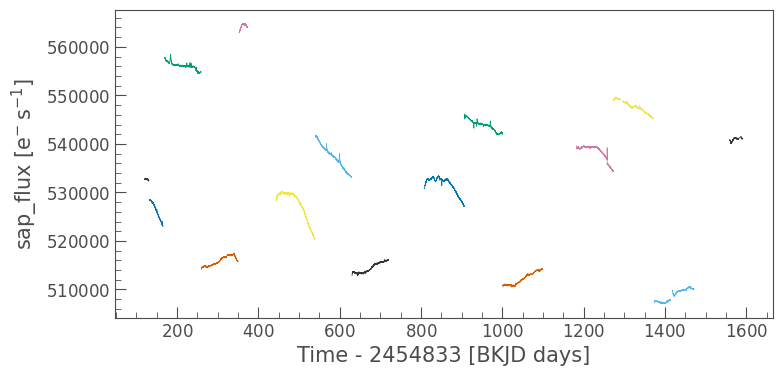

In [3]:
lc_collection = search_result.download_all()
ax = lc_collection[0].plot(column='sap_flux', label=None)
for lc in lc_collection[1:]:
    lc.plot(ax=ax, column='sap_flux', label=None)

<h2>Flat Lightcurve</h2>

Now, we can subtract the trend from the lightcurve, to obtain what is sometimes called a 'flat lightcurve'. The most obvious transits (i.e. Hot Jupiters) can be easily spotted at this point if they are present. After changing the Kepler number above, hit 'Update' to refresh the plot.

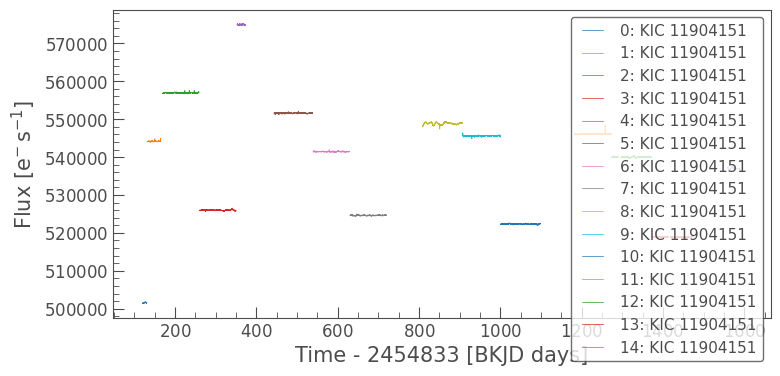

In [4]:
lc_collection.plot();

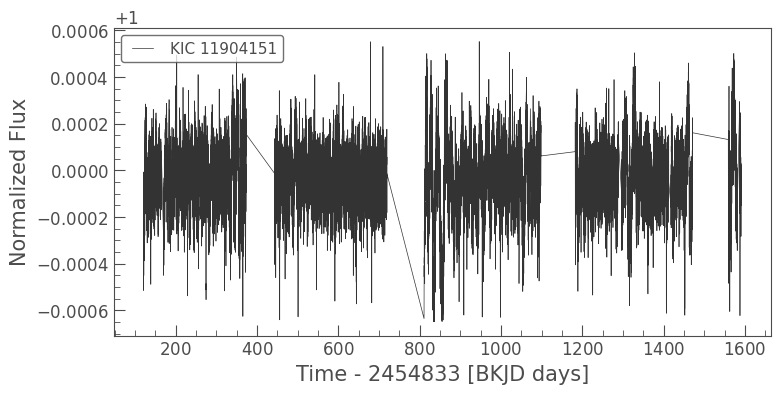

In [5]:
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot();

<h2>Determining the period</h2>

The next step is to determine whether there is a periodic dimming present in the flat lightcurve. You can think of this as doing a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) and look for the period where there is the highest power. In cases where the signal is very far from sinusoidal, other algorithms perform better than the Fourier transform. Here, we use a special algorithm for transits, called the [Box Least Squares](https://docs.astropy.org/en/stable/timeseries/bls.html) periodogram. Its output is very similar to a Fourier transform: power as a function of period (or frequency). The slider below can be used to change the search range for periods.

<Quantity 0.83748375 d>

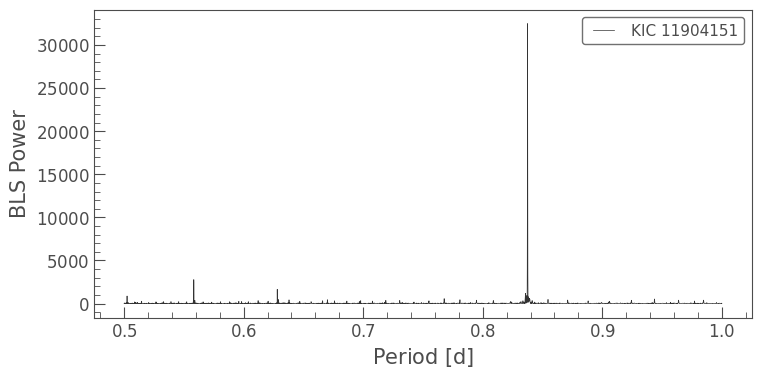

In [6]:
# Create array of periods to search
period = np.linspace(0.5, 1, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<h2>Folding the lightcurve</h2>

We can use the period $P$ where the BLS periodogram attains maximum power to create a 'folded' lightcurve. After every $P$, we reset the time to the initial time $t_0$, so that time runs from $t_0$ to $t_0+P$ only. This time interval is then scaled to unity and renamed 'phase', which runs from $-0.5$ to $0.5$. If the total observation time is 10 $P$ (say), this means that we get 10 lightcurves on top of each other. If a strong periodic signal is present, these lightcurves will strongly overlap, so that a transit is easy to see.    

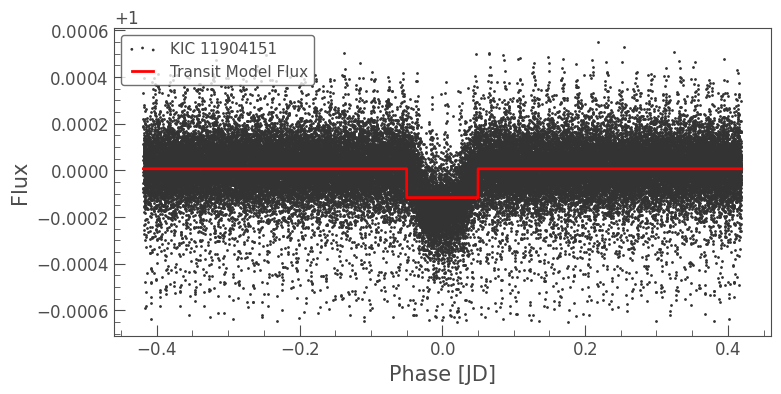

In [7]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()

# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2);

<Quantity 45.2970297 d>

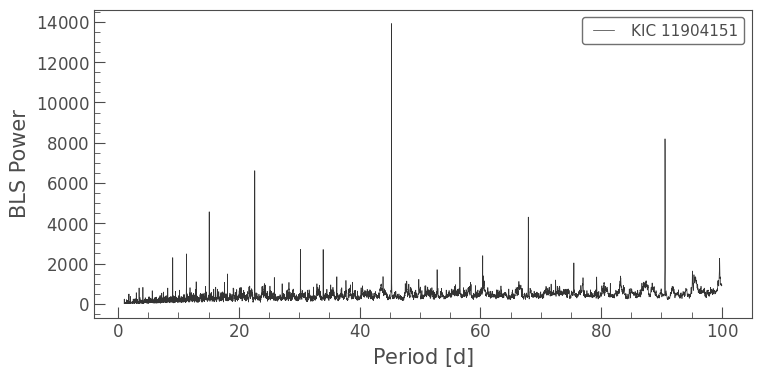

In [8]:
# Create a cadence mask using the BLS parameters
planet_b_mask = bls.get_transit_mask(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)
masked_lc = lc[~planet_b_mask]
#ax = masked_lc.scatter();
#lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked');

period = np.linspace(1, 100, 10000)
bls = masked_lc.to_periodogram('bls', period=period, frequency_factor=500)
bls.plot();

planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

# Check the value for period
planet_c_period

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

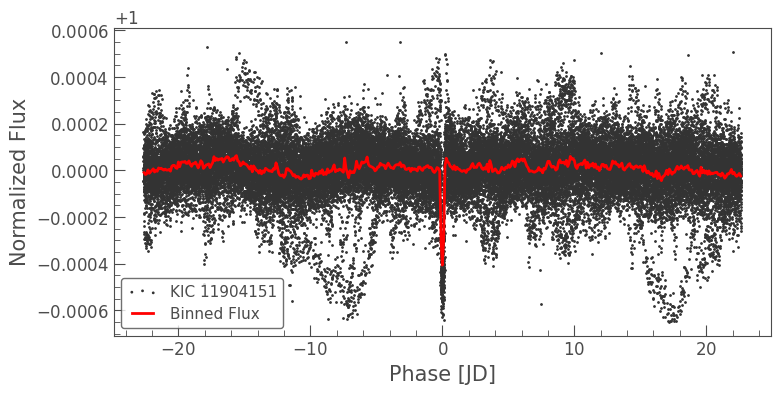

In [9]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
